In [1]:
import torch
import numpy as np
import pandas as pd

from src.data.core import GetData
from src.data import DataBlock
from typing import Literal
from copy import deepcopy
import torch
import torch.nn.functional as F

from src.environ import RISK_STYLE
from src.data.process import BlockLoader
from src.factor.plot_util import multi_factor_plot

class DataVendor:
    def __init__(self):
        self.start_dt = 99991231
        self.end_dt   = -1
        self.max_rtn_date = GetData.data_dates('trade' , 'day')[-1]
        self.trade_date = GetData.trade_dates()
        self.all_stocks = GetData.stocks().sort_values('secid')

    def td_within(self , start_dt : int = -1 , end_dt : int = 99991231 , step : int = 1):
        return self.trade_date[(self.trade_date >= start_dt) & (self.trade_date <= end_dt)][::step]

    def td_offset(self , date , offset : int = 0):
        if np.isscalar(date):
            if date not in self.trade_date: date = self.trade_date[self.trade_date <= date][-1]
            d = self.trade_date[np.where(self.trade_date == date)[0][0] + offset]
            return int(d)
        else:
            return np.array([self.td_offset(d , offset) for d in date])

    def random_factor(self):
        date  = self.td_within(20240101,20240531,5)
        secid = self.all_stocks.secid
        factor_val = DataBlock(np.random.randn(len(secid),len(date),1,2),secid,date,['factor1','factor2'])
        return factor_val

    def get_returns(self , start_dt : int , end_dt : int):
        td_within = self.td_within(start_dt , end_dt)
        if (not hasattr(self , 'day_ret')) or (not np.isin(td_within , self.day_ret.date).all()):
            self.day_ret  = GetData.daily_returns(start_dt , end_dt)

    def get_risk_exp(self , start_dt : int , end_dt : int):
        td_within = self.td_within(start_dt , end_dt)
        if (not hasattr(self , 'risk_exp')) or (not np.isin(td_within , self.risk_exp.date).all()):
            with GetData.Silence():
                self.risk_exp  = BlockLoader('models', 'risk_exp').load_block(start_dt , end_dt)

    def nday_fut_ret(self , secid : np.ndarray , date : np.ndarray , nday : int = 10 , lag : int = 2 , 
                     ret_type : Literal['close' , 'vwap'] = 'close'):
        assert lag > 0 , f'lag must be positive : {lag}'
        date_min  = int(self.td_offset(date.min() , -10))
        date_max  = int(self.td_offset(int(date.max()) , nday + lag + 10))
        self.get_returns(date_min , date_max)
        full_date = self.td_within(date_min , date_max)

        block = self.day_ret.align(secid , full_date , [ret_type] , inplace=False).as_tensor()
        block.values = F.pad(block.values[:,lag:] , (0,0,0,0,0,lag) , value = torch.nan)

        new_value = block.values.unfold(1 , nday , 1).exp().prod(dim = -1) - 1
        feature   = ['ret']

        new_block = DataBlock(new_value , secid , full_date[:new_value.shape[1]] , feature).align_date(date)
        return new_block
    
    def risk_style_exp(self , secid : np.ndarray , date : np.ndarray):
        self.get_risk_exp(date.min() , date.max())
        block = self.risk_exp.align(secid , date , RISK_STYLE , inplace=False).as_tensor()
        return block


In [2]:
from typing import Literal , Optional 

from src.data.fetcher import get_target_dates , load_target_file
from src.func import match_values

class Portfolio:
    def __init__(self , port : Optional[pd.DataFrame] , date : int = -1 , name : str = 'port') -> None:
        self.exists = port is not None 
        self.port = self.empty_port if port is None else port.groupby('secid')['weight'].sum().reset_index() 
        self.date = date
        self.name = name

    def __repr__(self): return repr(self.port)

    @classmethod
    def random(cls):
        date = np.random.randint(20200101 , 20231231)
        name = 'rand_port'
        port = pd.DataFrame({'secid' : np.arange(1,101) , 'weight' : np.random.rand(100)})
        return cls(port,date,name)

    @property
    def empty_port(self):
        return pd.DataFrame(columns=['secid','weight']).astype({'secid':int,'weight':float})
    
    @property
    def port_with_date(self):
        if len(self.port):
            return pd.DataFrame({'date':self.date , **self.port})
        else:
            return pd.DataFrame(columns=['date','secid','weight']).astype({'date':int,'secid':int,'weight':float})
        
    @property
    def secid(self): return self.port['secid'].to_numpy()
    @property
    def weight(self): return self.port['weight'].to_numpy()
    
class PortfolioStream:
    def __init__(self , portfolios : list[Portfolio] = []) -> None:
        self.ports = {f'{port.name}.{port.date}':port for port in portfolios}
        self.create_weight_block()

    def __repr__(self): return repr(self.ports)

    @classmethod
    def random(cls):  return cls([Portfolio.random() for _ in range(3)])

    def create_weight_block(self):
        secid = np.unique(np.concatenate([port.secid for port in self.ports.values()])) if self.ports else np.array([]).astype(int)
        date  = np.array([port.date for port in self.ports.values()]).astype(int)
        values = np.zeros((len(secid) , len(date) , 1 , 1))
        for i , port in enumerate(self.ports.values()):
            values[match_values(port.secid , secid),i,0,0] = port.weight
        self.weight = DataBlock(values , secid , date , ['weight']).align_date(np.sort(date))

    def stack(self):
        if self.ports:
            return pd.concat([pf.port_with_date for pf in self.ports.values()] , axis = 0)
        else:
            return pd.DataFrame(columns=['date','secid','weight']).astype({'date':int,'secid':int,'weight':float})
        
    def append(self , port : Portfolio):
        key = f'{port.name}.{port.date}'
        assert key not in self.ports.keys() , key
        self.ports[key] = port
        new_secid = np.union1d(self.weight.secid , port.secid)
        new_date  = np.union1d(self.weight.date  , port.date)
        self.weight = self.weight.align_secid_date(new_secid , new_date)
        i = match_values(port.secid , self.weight.secid)
        j = np.where(new_date == port.date)[0][0]
        self.weight.values[i,j,0,0] = port.weight[:]


    def get(self , name : str , date : int):
        key = f'{name}.{date}'
        return self.ports.get(key , None)

pf = Portfolio.random().port_with_date

In [3]:
from typing import Literal , Optional 

from src.data.fetcher import get_target_dates , load_target_file

class Benchmark:
    def __init__(self , name : Optional[Literal['csi300' , 'csi500' , 'csi1000']] = None) -> None:
        self.name = name
        if self.name is None:
            self.available_dates = None
        else:
            self.available_dates = get_target_dates('benchmark' , self.name)
        self.ports = PortfolioStream()

    def latest_avail_date(self , date : int = 99991231):
        if self.available_dates is None: return None
        if date in self.available_dates: return date
        tar_dates = self.available_dates[self.available_dates < date]
        return max(tar_dates) if len(tar_dates) else -1

    def get(self , date : int , latest = False):
        if self.name is None: return Portfolio(None , date , 'none')
        if (bm := self.ports.get(self.name , date)) is not None: return bm
        bm = load_target_file('benchmark' , self.name , date)
        if bm is None and latest: bm = load_target_file('benchmark' , self.name , self.latest_avail_date(date))
        port = Portfolio(bm , date , self.name)
        self.ports.append(port)
        return port

    def universe(self , secid : np.ndarray , date : np.ndarray):
        for i , d in enumerate(date): self.get(d , latest = i==0)
        weight = self.ports.weight.copy().align_secid_date(secid , date).as_tensor()
        weight.values = weight.values.nan_to_num(0) > 0
        weight.feature = ['universe']
        return weight
    
bm = Benchmark('csi300')
# bm.get(20240601 , True)

In [13]:
vendor = DataVendor()
factor_val = vendor.random_factor().to_dataframe()
benchmark  = Benchmark('csi300')

def factor_val_breakdown(factor_val : DataBlock | pd.DataFrame):
    if isinstance(factor_val , DataBlock):
        secid , date = factor_val.secid , factor_val.date
        factor_val = factor_val.to_dataframe()
    else:
        secid = factor_val.index.get_level_values('secid').unique().values
        date  = factor_val.index.get_level_values('date').unique().values
    return factor_val , secid , date


In [5]:
import numpy as np
import pandas as pd

def calc_distribution(factor_val : DataBlock | pd.DataFrame , sampling_date_num : int = 20 , hist_bins : int = 50):
    factor_val , secid , date = factor_val_breakdown(factor_val)
    date_chosen = date[::int(np.ceil(len(date) / sampling_date_num))]
    factor_list = factor_val.columns.tolist()
    factor_val_date = factor_val.reset_index(drop = False).set_index('date')
    rtn = []
    for factor_name in factor_list:
        hist_dict = {}
        for date in date_chosen:
            factor_sample = factor_val_date.loc[date, factor_name].copy()
            cnts, bins = np.histogram(factor_sample, bins=hist_bins, density=False)
            hist_dict[date] = (cnts, bins)
        hist_df = pd.DataFrame(hist_dict, index=['hist_cnts', 'hist_bins']).T
        hist_df['factor_name'] = factor_name
        rtn.append(hist_df)
    rtn = pd.concat(rtn, axis=0)
    rtn.index.rename('date', inplace=True)
    rtn = rtn.reset_index(drop=False).loc[:,['date' , 'factor_name', 'hist_cnts', 'hist_bins']]
    assert isinstance(rtn , pd.DataFrame)
    return rtn

a = calc_distribution(factor_val)

In [21]:
def _calc_factor_qtile_by_day(factor : pd.DataFrame , scaling : bool = True):
    if scaling: factor = (factor - factor.mean()) / factor.std()
    rtn = pd.concat([factor.quantile(q / 100).rename(f'{q}%') for q in (5,25,50,75,95)], axis=1, sort=True)
    return rtn

def calc_factor_qtile(factor_val : pd.DataFrame , scaling : bool = True):
    factor_val , _ , _ = factor_val_breakdown(factor_val)
    rtn = factor_val.groupby(['date']).apply(_calc_factor_qtile_by_day , scaling = scaling).\
        reset_index(drop=False).rename(columns={'level_1':'factor_name'})
    return rtn

a = calc_factor_qtile(factor_val , True)

[<Figure size 1600x700 with 1 Axes>, <Figure size 1600x700 with 1 Axes>]

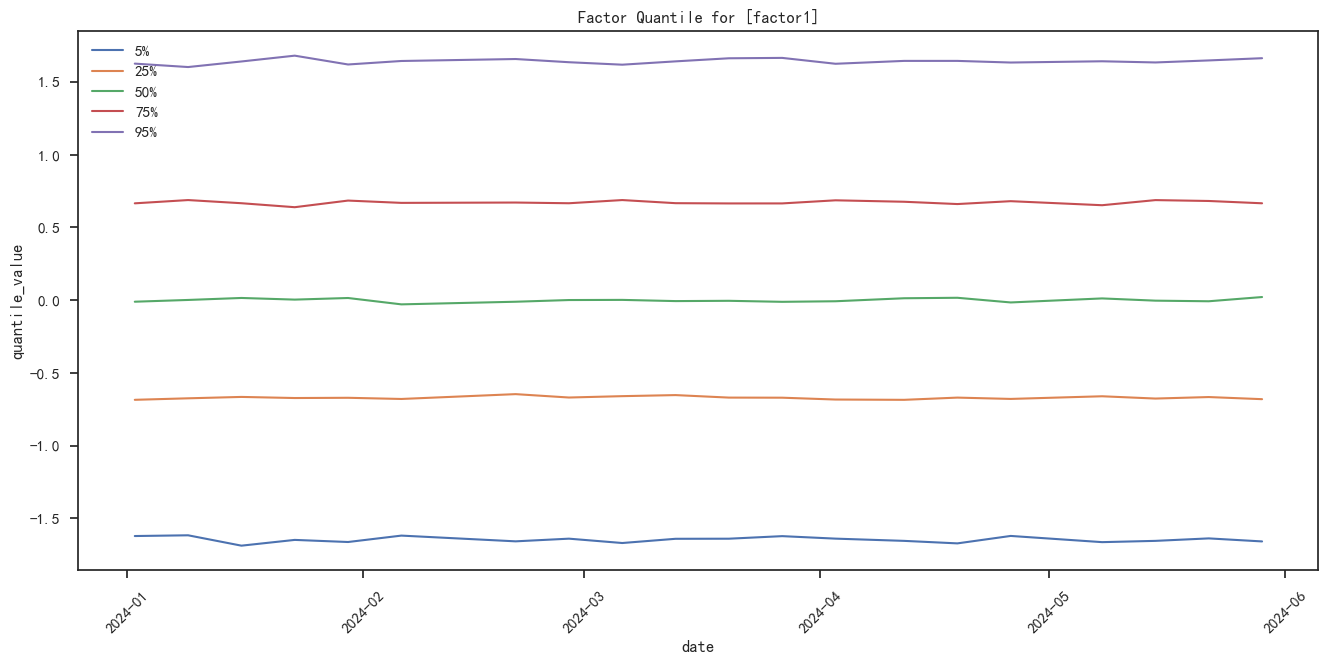

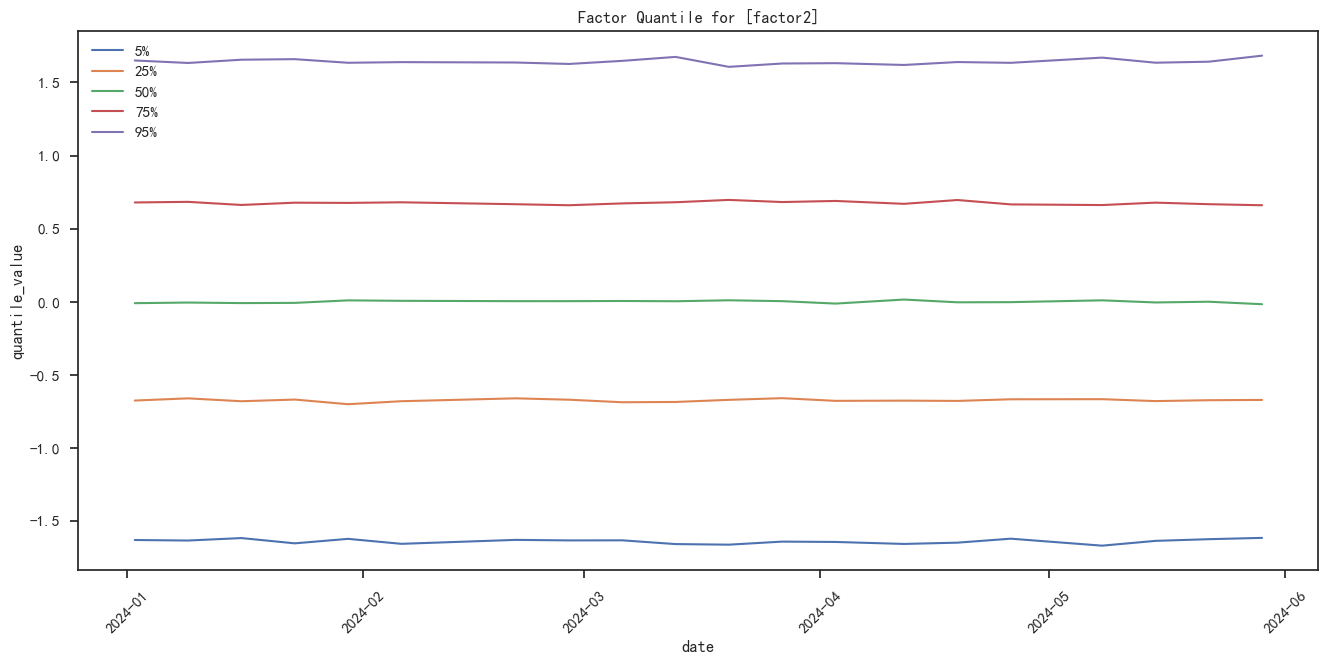

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from packaging import version

# for Chinese
sns.set_theme(context='notebook', style='ticks', font='SimHei', rc={'axes.unicode_minus': False})
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def pct_fmt(temp : float, position : int = 2): return f'{np.format_float_positional(temp * 100 , position)}%'

from src.factor.plot_util import multi_factor_plot , plot_head , plot_end

@multi_factor_plot
def plot_factor_qtile(df : pd.DataFrame , factor_name : Optional[str] = None):
    df , fig = plot_head(df , factor_name)

    df.columns.rename('quantile_name', inplace=True)
    df = df.set_index('date').stack().rename('quantile_value').reset_index(drop=False) # type: ignore
    df = df.assign(date=pd.to_datetime(df['date'].astype(str)), format='%Y%m%d')

    ax = sns.lineplot(x='date', y='quantile_value', hue='quantile_name', data=df)
    plt.grid()
    ax.set_title(f'Factor Quantile for [{factor_name}]')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[0:], labels=labels[0:], loc='upper left')
    plot_end()
    return fig

plot_factor_qtile(a)

<Figure size 1600x700 with 0 Axes>

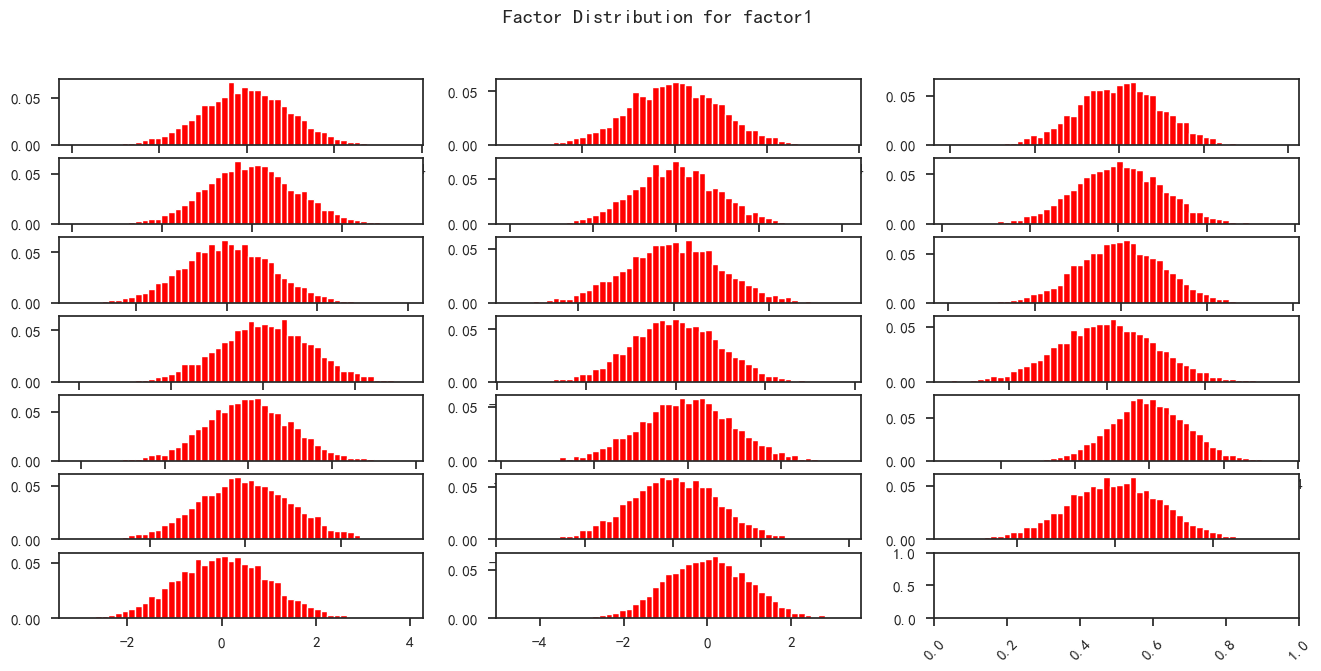

<Figure size 1600x700 with 0 Axes>

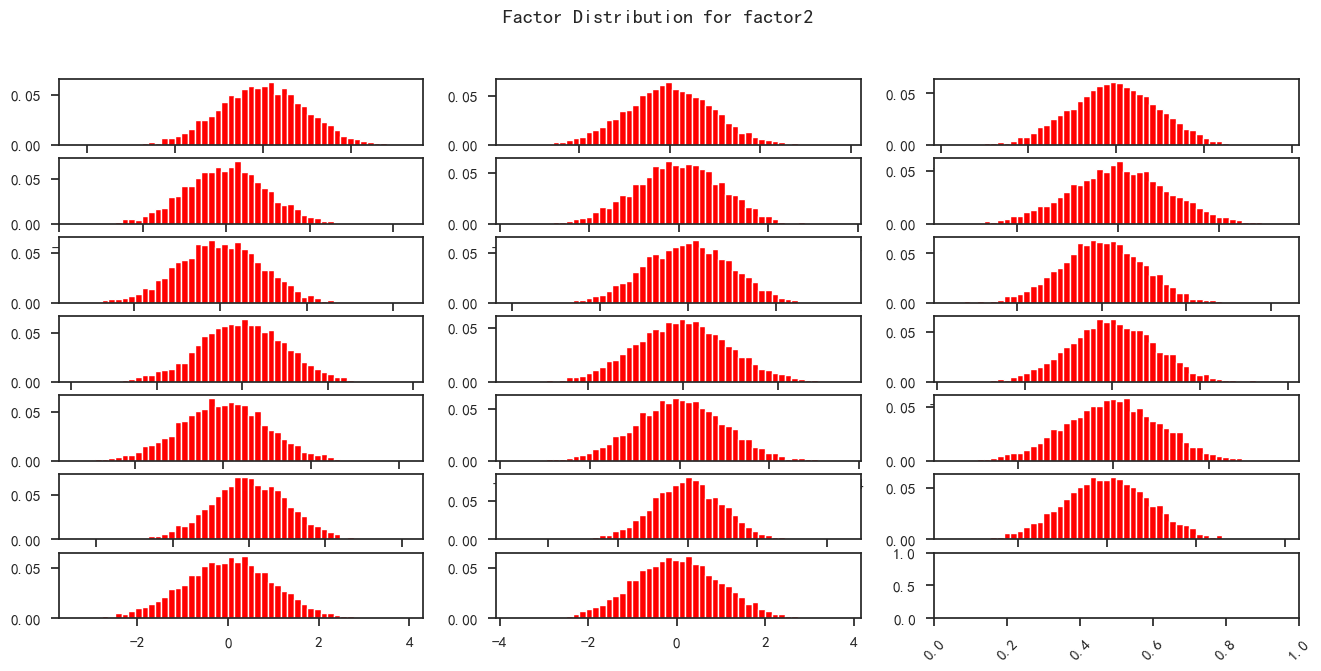

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from packaging import version

# for Chinese
sns.set_theme(context='notebook', style='ticks', font='SimHei', rc={'axes.unicode_minus': False})
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def pct_fmt(temp : float, position : int = 2): return f'{np.format_float_positional(temp * 100 , position)}%'

from src.factor.plot_util import multi_factor_plot , plot_head , plot_end

@multi_factor_plot
def plot_distribution(df : pd.DataFrame , factor_name : Optional[str] = None):
    df , fig = plot_head(df , factor_name)

    density_info = df
    assert not density_info['date'].duplicated().any()
    #
    col_num = 3
    row_num = int(np.ceil(len(density_info) / col_num))
    fig, axs = plt.subplots(row_num, col_num, figsize=(16, 7))
    for i in range(len(density_info)):
        day_density_info = density_info.iloc[i]
        bins = day_density_info['hist_bins']
        cnts = day_density_info['hist_cnts']
        cnts = cnts / cnts.sum()

        ax = axs[int(i / col_num), i % col_num]
        ax.bar(x=bins[:-1] + np.diff(bins) / 2, height=cnts, width=np.diff(bins), facecolor='red')

    fig.suptitle(f'Factor Distribution for {factor_name}')
    return fig
    
fig = plot_distribution(a)